These are data containing all the traces contained in the 'Kolumbo box' described in my thesis. In particular, there are no additional offset-constraints or hand-picked trace-removal.

#### Notebook config

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2

In [9]:
import fwipy 
from fwipy import *
from fwipy.config.logging import *
from fwipy.ioapi.segy import SgyFile
lll(40)

In [10]:
help(fwipy)

Help on package fwipy:

NAME
    fwipy

PACKAGE CONTENTS
    config (package)
    dsp (package)
    fd (package)
    fwi (package)
    generic (package)
    ioapi (package)
    ndat (package)
    numeric (package)
    plot (package)
    project (package)
    seismic (package)
    utils

FILE
    /home/kajetan/software/Kolumbo-FWI/fwipy/__init__.py




#### Example lines

In [11]:
tracf = 4112
ep = 8

#### Developing interlacing

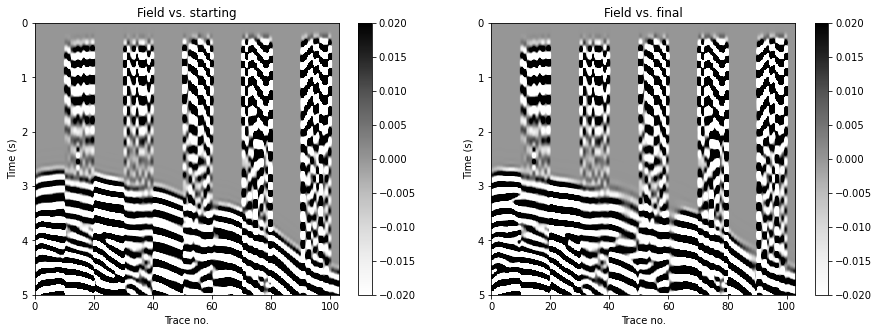

In [155]:
def compare_data(sgy1, sgy2, tracf, ep, dt=0.0025, cmap='Greys', tmin=None, tmax=None,
                vmin=None, vmax=None):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    t1 = 0
    t2 = a1.shape[-1] * dt
    x1 = 0
    x2 = a1.shape[0]
    a = interleave_arrays(a1, a2)
    plt.imshow(a.T, aspect='auto', extent=[x1, x2, t2, t1],
               cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel('Trace no.')
    plt.ylabel('Time (s)')
    plt.ylim(tmax, tmin)
figure(15,5)
plt.subplot(121)
plt.title('Field vs. starting')
compare_data(sgy000, sgyobs, tracf, ep, tmin=0, tmax=5, vmin=-.02, vmax=.02)
plt.subplot(122)
plt.title('Field vs. final')
compare_data(sgy160, sgyobs, tracf, ep, tmin=0, tmax=5, vmin=-.02, vmax=.02)    

#### Old wiggle plots

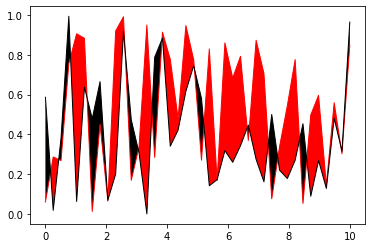

In [5]:
# plot_2_series 
from fwipy.utils import plot_2_series
ns = 40
x = np.linspace(0,10,ns)
y1 = np.random.rand(ns)
y2 = np.random.rand(ns)
plot_2_series(x, y1, y2, c1='k', c2='r')

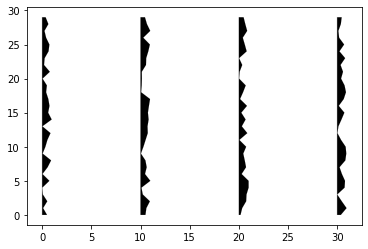

In [57]:
# plot_wiggles
from fwipy.utils import plot_wiggles
Z = np.random.rand(4,1,30)
plot_wiggles(Z)

#### Developing wiggle plots

In [82]:
%matplotlib inline

(4.0, 0.0)

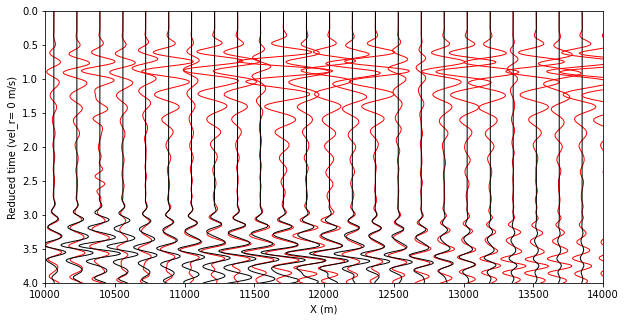

In [155]:
def compare_wiggles(sgy1, sgy2, tracf, ep, dt=0.0025, 
                    A1=100, A2=100,
                    tmin=None, tmax=None,
                 vel_red = 5000, # reduction velocity (m/s)
                 lw = 1, l1='field', l2=None, c_line1 = 'r', c_line2='k', figsize=(10,5),
                cmap='Greys', vmin=None, vmax=None):
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='max')
    ntr, ns = a1.shape
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    fig, ax = plt.subplots(figsize=figsize)
    for i, x in enumerate(h.sx):
        if abs(vel_red) > 1e-3:
            t = np.arange(0, ns) * dt - x / vel_red
        else:
            t = np.arange(0, ns) * dt
        offset_weight = h.offset[h.offset.index[i]] / 8000
        ax.plot(x + a1[i] * offset_weight * A1, t, color=c_line1, lw=lw, label=l1)
        ax.plot(x + a2[i] * offset_weight * A2, t, color=c_line2, lw=lw, label=l2)
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    plt.ylabel('Reduced time (vel_r= %s m/s)' % vel_red)
compare_wiggles(sgyobs, sgy160, tracf, ep, vel_red=0, A1=1000, A2=200)
plt.xlim(1e4, 1.4e4)
plt.ylim(4,0)
# plt.

(5.0, 0.0)

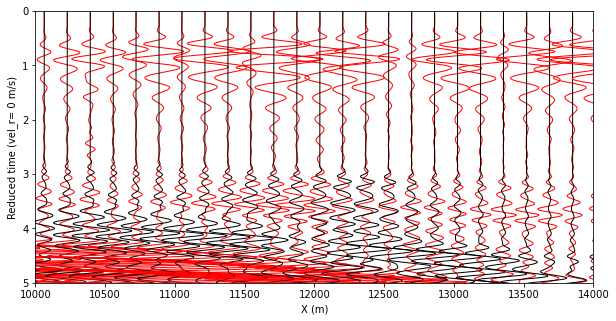

In [153]:
compare_wiggles(sgyobs, sgy000, tracf, ep, vel_red=0, A1=1000, A2=200)
plt.xlim(1e4, 1.4e4)
plt.ylim(5,0)

#### Developing wiggle plots - offset3D

In [82]:
%matplotlib inline

In [164]:
def calc_offset3d(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    df['offset3d'] = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    return df['offset3d']
# calc_offset3d(h)

In [215]:
def calc_offset3d_signed(df):
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
    
    offset3d = np.sqrt((df['sx'] - df['gx'])**2 +
                             (df['sy'] - df['gy'])**2 +
                             (df['selev'] + df['gelev'])**2)
    df['offset3d'] = offset3d
    df['offset3d_signed'] = np.where(df['sx'] >= df['gx'], offset3d, -offset3d)
    return df['offset3d_signed']

In [277]:
import pandas as pd
def sx2offset(x):
    #d = dict(zip(list(h.sx.values), list(h.offset3d.values)))
    s = pd.Series(data=h.offset3d.values, index=h.sx.values)
    return s[x].values
def offset2sx(x):
    s = pd.Series(data=h.sx.values, index=h.offset3d.values)
    return s[x].values
sx2offset([8105, 8258])

array([6264.94333574, 6168.14672329])

In [278]:
# h.sx, h.offset3d

[6264, 6333, 7999, 10452, 13282, 16287]


(5.0, 0.0)

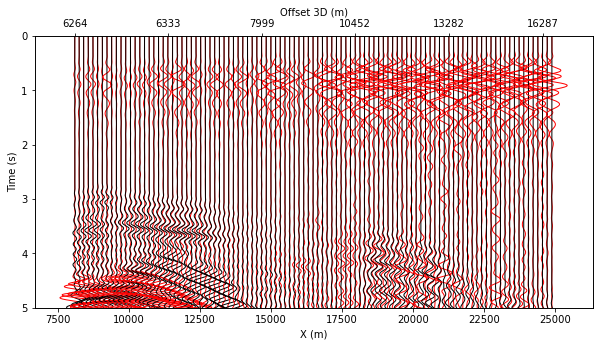

In [343]:
def compare_wiggles(sgy1, sgy2, tracf, ep, dt=0.0025, 
                    A1=100, A2=100,
                    tmin=None, tmax=None,
                 #geom_factor=8000,
                 vel_red = 5000, # reduction velocity (m/s)
                 lw = 1, l1='field', l2=None, c_line1 = 'r', c_line2='k', figsize=(10,5),
                cmap='Greys', vmin=None, vmax=None):
    import pandas as pd
    from fwipy.ndat.arrays import Arr2d, modify_array, interleave_arrays
    a1 = modify_array(sgy1.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    a2 = modify_array(sgy2.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0)[:,0,:], norm='rms')
    ntr, ns = a1.shape
    h = sgy1.read_header(overwrite=0)
    h = h.loc[(h.tracf==tracf) & (h.ep==ep)]
    calc_offset3d(h)
    fig, ax = plt.subplots(figsize=figsize)
    zero_vel = 1e-3
    for i, (x, offset3d) in enumerate(zip(h.sx, h.offset3d)):
        if abs(vel_red) > zero_vel:
            t = np.arange(0, ns) * dt - offset3d / vel_red
        else:
            t = np.arange(0, ns) * dt
        #ax.plot(x + a1[i] * (offset3d / geom_factor) * A1, t, color=c_line1, lw=lw, label=l1)
        #ax.plot(x + a2[i] * (offset3d / geom_factor) * A2, t, color=c_line2, lw=lw, label=l2)
        ax.plot(x + a1[i] * A1, t, color=c_line1, lw=lw, label=l1)
        ax.plot(x + a2[i] * A2, t, color=c_line2, lw=lw, label=l2)
    
    ax.invert_yaxis()    
    plt.xlabel('X (m)')
    if abs(vel_red) > zero_vel:
        plt.ylabel('Reduced time (s) for vel_r= %s m/s' % vel_red)
    else:
        plt.ylabel('Time (s)')
#         def sx2offset(x):
#             #d = dict(zip(list(h.sx.values), list(h.offset3d.values)))
#             s = pd.Series(data=h.offset3d.values, index=h.sx.values)
#             return s[x].values
#         def offset2sx(x):
#             s = pd.Series(data=h.sx.values, index=h.offset3d.values)
#             return s[x].values
        #ax.secondary_xaxis('top', functions=(sx2offset, offset2sx))
    #     ax.get_xticks()
    ax2 = ax.twiny()
    x1, x2 = ax.get_xbound()
    ax2.set_xbound(x1,x2)
    every = 20
    xticks = h.sx.values[::every]
    xlabels = [int(i) for i in h.offset3d[::every]]
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xlabels)
    ax2.set_xlabel("Offset 3D (m)")
    #plt.xlim(h.sx[h.index[0]], h.sx[h.index[-1]])
compare_wiggles(sgyobs, sgy160, tracf, ep, vel_red=0, A1=100, A2=50)

# plt.xlim(1.4e4, 1.8e4)
plt.ylim(5,0)

In [331]:
ax.get_xbound()

(0.0, 1.0)

In [328]:
dir(ax)

['ArtistList',
 '_PROPERTIES_EXCLUDED_FROM_SET',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_text',
 '_adjustable',
 '_agg_filter',
 '_alias_map',
 '_alpha',
 '_anchor',
 '_animated',
 '_aspect',
 '_autoscaleXon',
 '_autoscaleYon',
 '_autotitlepos',
 '_axes',
 '_axes_class',
 '_axes_locator',
 '_axis_names',
 '_axisbelow',
 '_box_aspect',
 '_callbacks',
 '_check_no_units',
 '_children',
 '_clipon',
 '_clippath',
 '_cm_set',
 '_colorbars',
 '_convert_dx',
 '_current_image',
 '_default_contains',
 '_deprecate_noninstance',
 '_facecolor',
 '_fill_between_x_or_y',
 '_frameon',
 '_gci',
 '_gen_axes_patch',
 '_gen_axes_spines',
 '_

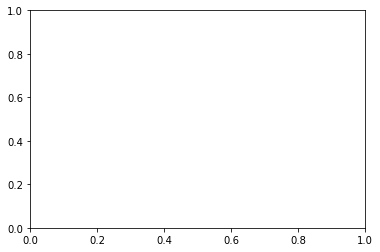

In [327]:
fig, ax = plt.subplots()
# ax.get_xticks()
# ax.get_xticklabels()
# ax.set_xticks([1,2])
# ax.set_xticklabels([1,2])

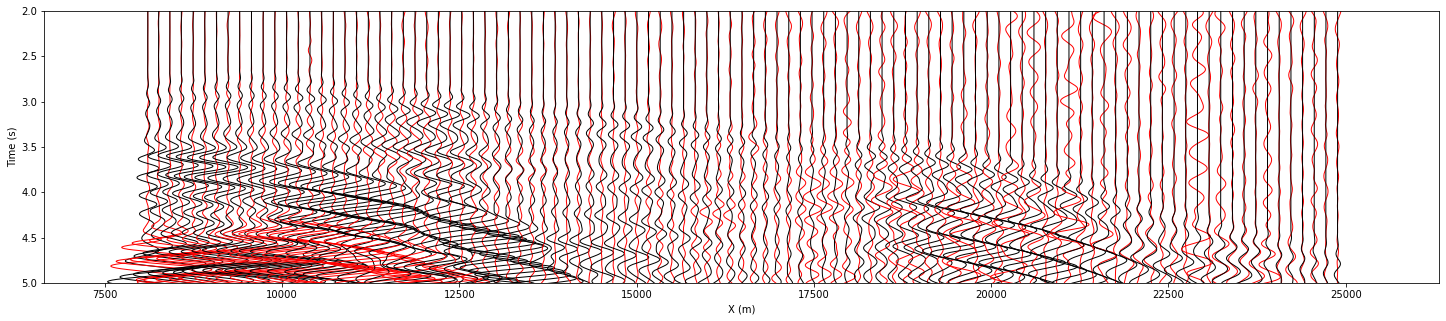

In [262]:
compare_wiggles(sgyobs, sgy000, tracf, ep, vel_red=0, A1=100, A2=100, figsize=(25,5))
# plt.xlim(1e4, 1.4e4)
# plt.xlim(1.4e4, 1.8e4)
plt.ylim(5,2)
plt.savefig('test.png')

(5.0, 0.0)

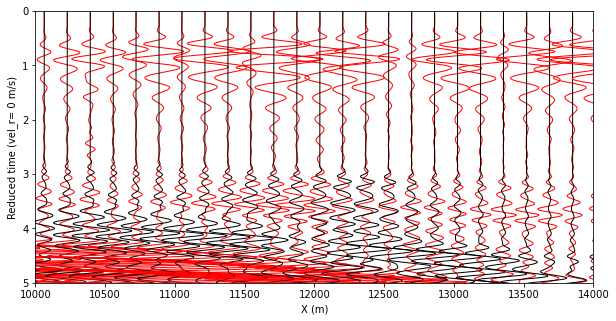

In [153]:
compare_wiggles(sgyobs, sgy000, tracf, ep, vel_red=0, A1=1000, A2=200)
plt.xlim(1e4, 1.4e4)
plt.ylim(5,0)

# Field data
Filtered as in the PhD thesis.

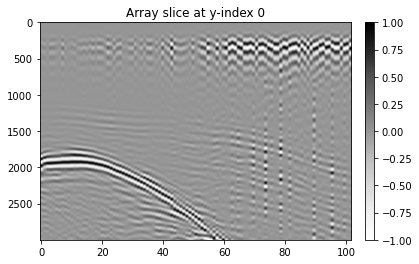

In [55]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_field_filtered.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgyobs = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the starting model.

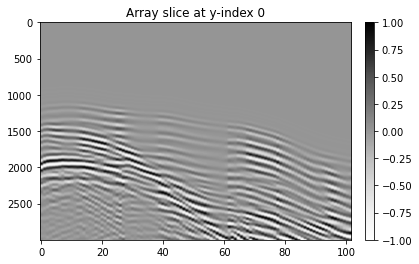

In [149]:
# plot example line 
file_name = 'data_kolumbo_PhD_all_traces_synth_it000.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy000 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

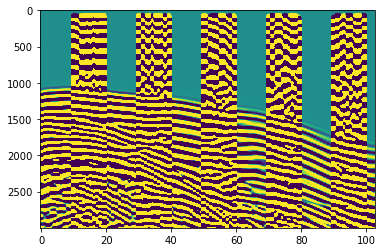

In [94]:
# plot example line 
a1 = sgy000.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

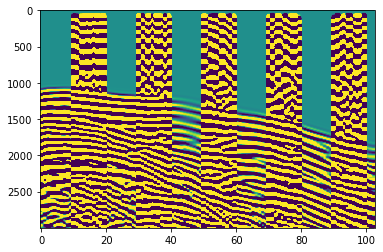

In [95]:
# plot example line 
a1 = sgy020.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

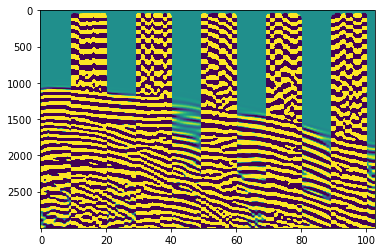

In [97]:
# plot example line 
a1 = sgy080.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

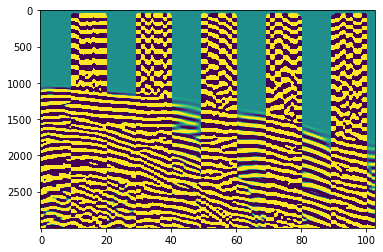

In [99]:
# plot example line 
a1 = sgy160.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
a2 = sgyobs.read(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')[:,0,:]
from fullwavepy.ndat.arrays import interleave_arrays
a = interleave_arrays(a1, a2)
plt.imshow(a.T, aspect='auto', vmin=-1, vmax=1)

# Synthetics
From the model after 020 iterations.

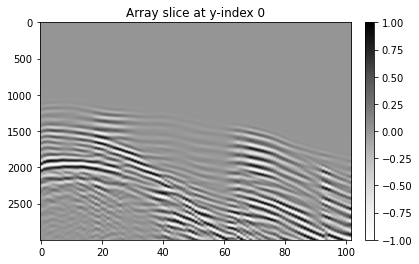

In [93]:
# plot example line 
file_name = 'p14it020syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy020 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 080 iterations.

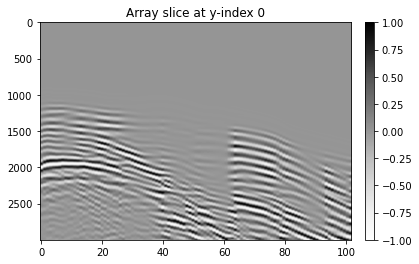

In [96]:
# plot example line 
file_name = 'p14it080syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy080 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Synthetics
From the model after 160 iterations.

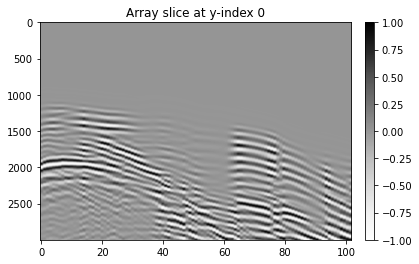

In [54]:
# plot example line 
file_name = 'p14it160syn-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy160 = sgy
_ = sgy.plot(win=dict(tracf=[tracf],ep=[ep]), overwrite=0, norm='max')

# Interleaving
Field vs. synthetics

In [156]:
# read ids 
file_name = 'method_s01-Synthetic.sgy'
data_path = '../data/'
sgy = SgyFile(file_name, data_path)
sgy1 = sgy
OBS_ids = sorted(sgy.read_header().tracf.unique())
print(OBS_ids)
shot_line_ids = sorted(sgy.head.ep.unique())
print(shot_line_ids)

[4104, 4105, 4109, 4110, 4112, 4123, 4124, 4125, 4137, 4138, 4139, 4157, 4158, 4176, 4177, 4178]
[5, 6, 7, 8, 9, 10, 22, 23, 26, 27, 30, 31, 37, 38]


In [162]:
def compare_start_vs_final_fits(sgyobs, sgy000, sgyrec, tracf, ep, tmin=0, tmax=5, vmax=.02):
    vmin = -vmax
    figure(15,5)
    plt.subplot(121)
    plt.title('Field vs. starting')
    compare_data(sgy000, sgyobs, tracf, ep, tmin=tmin, tmax=tmax, vmin=vmin, vmax=vmax)
    plt.subplot(122)
    plt.title('Field vs. recovered')
    compare_data(sgyrec, sgyobs, tracf, ep, tmin=tmin, tmax=tmax, vmin=vmin, vmax=vmax)    

In [166]:
%%time 
for it in [20, 80, 160]:
    sgysyn = {20: sgy020, 80: sgy080, 160: sgy160}
    for sid in OBS_ids:
        for lid in shot_line_ids:
            try:
                compare_start_vs_final_fits(sgyobs, sgy000, sgysyn[it], sid, lid)
            except AssertionError:
                print('WARNING no data for OBS %s, line %s' % (sid, lid))
            plt.savefig('figures/interlaced_broadband/p14_BB_OBS%s_line%s_it%s.png' % (sid, str(lid).rjust(3, '0'), str(it).rjust(3, '0')))
            plt.close()

CPU times: user 8min 15s, sys: 5min 34s, total: 13min 50s
Wall time: 1h 29min 55s


# ...